<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект классификации отзывов

Интернет-магазин  запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Перед нами задача классификации текстов: необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Задача от заказчика: получение на модели метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим необходимые библиотеки, выполним загрузку недостающих пакетов и откроем файл.

In [1]:
import os

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pickle
import re 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as make_pipeline_imb

from joblib import Parallel, delayed

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [2]:
nltk.download('wordnet')# пакет для WordNetLemmatizer
nltk.download('omw-1.4') # аналогично
nltk.download('stopwords')# пакет для очистки от не несущих смысловую нагрузку слов

[nltk_data] Downloading package wordnet to /Users/iair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/iair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/iair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pth0 = '/Users/iair/Documents/Документы Алена/Яндекс_практикум/Machine_learning_for_texts/toxic_comments.csv'
pth1 = '/datasets/toxic_comments.csv'
if os.path.exists(pth0):
    df = pd.read_csv(pth0)
elif os.path.exists(pth1):
    df = pd.read_csv(pth1)
else:
    print("Проверьте правильность пути к датасету")

In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


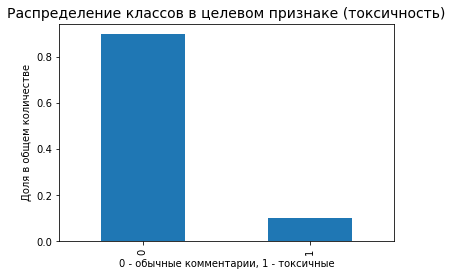

In [5]:
class_frequency = df['toxic'].value_counts(normalize=(0,1))#посчитаем долю каждого класса
g = class_frequency.plot(kind='bar')
g.axes.set_title("Распределение классов в целевом признаке (токсичность)", fontsize=14)
g.set_xlabel("0 - обычные комментарии, 1 - токсичные", fontsize=10)
g.set_ylabel("Доля в общем количестве", fontsize=10);
plt.show()

In [6]:
df[df['toxic'] ==1]['text'].count()/len(df['toxic'])

0.10161213369158527

Итак, у нас в наличии "сырые" твиты на английском языке, размеченные по градации токсичный/ не токсичный. Всего токсичных твитов чуть более 10%.
Выполним подготовку текста: очистим и лемматизируем текст, добавим его в отдельную колонку датафрейма. 

Напишем функции лемматизации и очистки текста от спецсимволов и лишних пропусков.

In [7]:
def lemmatize(text):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemm_list = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    lemm_text = " ".join(lemm_list)
        
    return lemm_text


def clear_text(text):
    x = re.sub(r'[^a-zA-Z]', ' ', text)
    y = " ".join(x.split())
    return y

Создадим столбец, куда поместим сразу очищенный и лемматизированный текст для дальнейшей обработки.

In [8]:
%%time
df['lemm_text'] = df['text'].apply(lambda x: clear_text(lemmatize(x)))

CPU times: user 26.8 s, sys: 171 ms, total: 27 s
Wall time: 27 s


Соответственно, выделим из нашего датасета признаки (лемматизированный текст, т.к. именно его можно далее трансформировать в вектор) и целевой признак (токсичные комментарии).

In [9]:
features = df['lemm_text']
target = df['toxic']

Разделим выборку на тренировочную и тестовую. Возьмем классическую пропорцию 75%/25%, стратифицируем по целевому признаку для пропорциональности разделения.

In [10]:
train_features, test_features, train_target, test_target = train_test_split(
    features,
    target,
    test_size=0.25,
    stratify = target)

Теперь преобразуем признаки в векторный вид и закодируем частоту употреблений отдельных слов встречается во всём корпусе и в отдельном его тексте. 

In [11]:
stopwords = set(nltk_stopwords.words('english'))

Признаки готовы, можно начинать обучение.

## Обучение

Перед обучением вспомним о том, что целевой класс представлен только в 10% случаев. Чтобы сбалансировать данные, применим готовое решение в imblearn и выполним oversamplingс помощью SMOTE, который создаст недостающий объем элементов малого класса путем синтеза их из ближайших соседей.

Напишем функцию, которая позволит нам подавать на вход модель, параметры и данные, проводить их через векторизацию, выполнять сэмплирование данных и передавать это все в модель с поиском наилучших параметров через Grid.

In [18]:
def make_some_pipe (model_name, model, parameters, features_train, target_train):
    
    #oversample with SMOTE + 
    pipeline = make_pipeline_imb(TfidfVectorizer(stop_words=stopwords),
                            SMOTE(
                                sampling_strategy='minority',random_state=12345),
                            shuffle(random_state=12345),
                            model
                           )
    gs = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, scoring = 'f1')
    print('\nEstimator: %s' % model_name)
    gs.fit(features_train, target_train)
    print('Best training F1: %.3f' % gs.best_score_)
    dump_file = 'best_estimator.pkl'
    joblib.dump(gs.best_estimator_, dump_file, compress=1)
    print('\nSaved %s grid search pipeline to file: %s' % (model_name, dump_file))

In [19]:
%%time
make_some_pipe(model_name = 'LogisticRegression',
               model = LogisticRegression(
                   random_state=12345,max_iter=2000,class_weight = 'balanced'
               ),
               parameters = [{'logisticregression__C':[1.0, 0.5]}],
               features_train = train_features,
               target_train = train_target)


Estimator: LogisticRegression
Best training F1: 0.674

Saved LogisticRegression grid search pipeline to file: best_estimator.pkl
CPU times: user 31.4 s, sys: 8.48 s, total: 39.8 s
Wall time: 46.9 s


In [20]:
model_reg = joblib.load('best_estimator.pkl')
joblib.dump(model_reg, 'model_reg.pkl', compress=1)

['model_reg.pkl']

Полученный результат недостаточен требований заказчика, однако следует отметить, что точность может быть ниже на тестовых данных. Проверим еще модель случайного леса.

In [21]:
%%time
make_some_pipe(model_name = 'RandomForestClassifier',
               model = RandomForestClassifier(random_state=12345, class_weight = 'balanced'),
               parameters = [{'randomforestclassifier__n_estimators': range (100, 200, 25),
              'randomforestclassifier__max_depth': range (1,11)}],
               features_train = train_features,
               target_train = train_target)


Estimator: RandomForestClassifier
Best training F1: 0.372

Saved RandomForestClassifier grid search pipeline to file: best_estimator.pkl
CPU times: user 24.1 s, sys: 19.9 s, total: 44 s
Wall time: 9min 14s


In [22]:
model_forest = joblib.load('best_estimator.pkl')
joblib.dump(model_forest, 'model_forest.pkl', compress=1)

['model_forest.pkl']

Логистическая регрессия дает результат лучше, при этом результат может быть получен гораздо быстрее, что больше отвечает интересам бизнеса. Проверим еще LGBM.

In [23]:
%%time
make_some_pipe(model_name = 'LGBM',
               model = lgb.LGBMClassifier(random_state=12345)
               parameters = [{'lgbmclassifier__n_estimators': range (100,300,50),
                              'lgbmclassifier__max_depth':(3,12)}],
               features_train = train_features,
               target_train = train_target)


Estimator: LGBM
Best training F1: 0.697

Saved LGBM grid search pipeline to file: best_estimator.pkl
CPU times: user 3min 13s, sys: 20.4 s, total: 3min 34s
Wall time: 8min 14s


In [24]:
model_lgdb = joblib.load('best_estimator.pkl')
joblib.dump(model_lgdb, 'model_lgdb.pkl', compress=1)

['model_lgdb.pkl']

Данная модель дает наилучший результат и достаточно быстро.

Следует отметить, что возможно выбор оверсэмплинга не совсем отвечает структуре данных (только 10% комментариев реально токсичные), а также в приниципе подходит задаче классификации текстов, проверим результат в случае замены в функции smote на нашу самописную функцию downsampling.

In [25]:
len(train_features[target == 1])/len(train_features[target == 0])

0.11311015662123004

In [26]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [27]:
features_downsampled, target_downsampled = downsample(train_features, train_target, 0.25)

In [28]:
def make_some_pipe_down_s (model_name, model, parameters, features_train, target_train):
    
    #oversample with SMOTE + 
    pipeline = make_pipeline_imb(TfidfVectorizer(stop_words=stopwords),model)
    gs = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, scoring = 'f1')
    print('\nEstimator: %s' % model_name)
    gs.fit(features_train, target_train)
    print('Best training F1: %.3f' % gs.best_score_)
    dump_file = 'best_estimator.pkl'
    joblib.dump(gs.best_estimator_, dump_file, compress=1)
    print('\nSaved %s grid search pipeline to file: %s' % (model_name, dump_file))

In [29]:
%%time
make_some_pipe_down_s(model_name = 'LGBM',
               model = lgb.LGBMClassifier(random_state=12345),
               parameters = [{'lgbmclassifier__n_estimators': range (100,300,50),
                              'lgbmclassifier__max_depth':(3,12),
                              'learning_rate':(0.001,0.03,0.1)}],
               features_train = features_downsampled,
               target_train = target_downsampled)


Estimator: LGBM
Best training F1: 0.831

Saved LGBM grid search pipeline to file: best_estimator.pkl
CPU times: user 35.7 s, sys: 5.32 s, total: 41 s
Wall time: 55.3 s


In [30]:
model_lgdb_down = joblib.load('best_estimator.pkl')
joblib.dump(model_lgdb_down, 'model_lgdb_down.pkl', compress=1)

['model_lgdb_down.pkl']

Итого замена SMOTE на downsampling дала наилучшие результаты, поэтому остановимся именно на LGBM, обученной на данных, прошедших через downsampling.

## Выводы

In [31]:
model_lgbm_down = joblib.load('model_lgdb_down.pkl')
predicted_test = model_lgbm_down.predict(test_features)
print("F1 модели lgbm на тестовой выборке:{:.2f}".format(
    f1_score(test_target, predicted_test)))

F1 модели lgbm на тестовой выборке:0.77


In [32]:
report = classification_report(test_target, predicted_test,
                               target_names=['Non-toxic', 'Toxic'])
print(report)

              precision    recall  f1-score   support

   Non-toxic       0.97      0.98      0.97     35777
       Toxic       0.79      0.75      0.77      4046

    accuracy                           0.95     39823
   macro avg       0.88      0.86      0.87     39823
weighted avg       0.95      0.95      0.95     39823



Итого мы получили на тестовых данных значение f1 для предсказания класса токсичных комментариев в 0,77, при этом отдельно полнота составила 0,76 (т.е. 76% токсичных комментариев модель находит корректно), а точность - 0,78 (т.е. в 78% случаев комментарии, обозначенные моделью как токсичные, действительно были таковыми).

Построим ROC-кривую, а также найдем площадь образуемой ею фигуры (AUC-ROC) для понимания соотношения корректно найденных моделью токсичных комментариев и тех, кого она неверно обозначила в прогнозе как токсичных. Для наглядности результатов добавим на график прямую, обозначающую модель, которая случайным образом выдает вероятность того, что твит является токсичным.

AUC-ROC модели на тестовой выборке:0.9576


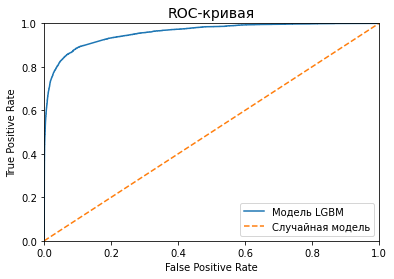

In [34]:
probabilities_test = model_lgbm_down.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]
print("AUC-ROC модели на тестовой выборке:{:.4f}".format(roc_auc_score(test_target, probabilities_one_test)))

fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)
plt.plot(fpr, tpr, label='Модель LGBM')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.title("ROC-кривая", fontsize=14)

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')# добавим для наглядности график случайной модели
plt.legend()
plt.show()

Итого данная модель отвечает требованиям заказчика, результат по целевой метрике F1 0,77, что соответсвует тех. заданию, при этом модель и вся подготовка работают достаточно быстро, чтобы в онлайн режиме отсеивать токсичные комментарии.